In [3]:
#!pip install bioinfokit
#!pip install kmodes
#!pip install dython
#!pip install plotly==4.10.0

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import binom, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
from bioinfokit.analys import stat, get_data
from kmodes.kprototypes import KPrototypes

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
PATH = Path('/content/drive/My Drive')

**Summary**


1.   This is a dataset with 7273 records and 8 features. Four out of the eight features are categorical variables. It contains 6887 unique patient IDs (employee + dependent).
3.   Clinic C has the highest number of unique patient IDs (37%), followed by clinic A (35%), and clinic B (28%). Both the employees and dependents have visited a clinic at least once.
4.   By examining the distribution of ageNBR, it appears that the dataset contains patients with a fairly even distribution across different age groups.
5.   The distributions for RiskNBR and VisitsCNT are right-skewed, with the majority of patients having a lower RiskNBR and an average value of 0.989636.
6.   The chi-square test results for all categorical variables show that the p-value for clinicID and modalityDSC is 4.00595e-132, indicating a strong association (p-value < 0.05). Additionally, the point-biserial correlation test between categorical and continuous variables reveals that the p-value for Modality_class and VisitsCNT is statistically significant, indicating a correlation between these two variables.
7. In conclusion, most clinics offer the same types of services that patients typically utilize, with only a few locations lacking certain services. The number of visits is influenced by the type of services patients seek. For example, chiropractic care, acupuncture, physical therapy, and mental health are the top four most popular services across all clinic locations. Massage therapy is the fifth most popular service, particularly at Clinic B."
8. In this dataset, only 5% of the patient population (280 out of 6,088) who visited a clinic have utilized more than one service.


#Data Exploration

In [7]:
raw_data = pd.read_csv(PATH/'XO_TakeHome_Data.csv')

In [8]:
raw_data.shape

(7273, 8)

In [9]:
raw_data.PatientID.nunique()

6887

In [10]:
raw_data.dtypes

PatientID            int64
AgeNBR               int64
GenderCD            object
RelationshipDSC     object
ClinicID            object
ModalityDSC         object
VisitsCNT            int64
RiskNBR            float64
dtype: object

In [11]:
raw_data.describe()

,PatientID,AgeNBR,VisitsCNT,RiskNBR
count,7273.000000,7273.000000,7273.000000,6937.000000
mean,102272.129520,58.753609,2.374123,0.989636
std,58336.218918,23.743300,3.599425,0.988562
min,85.000000,18.000000,1.000000,0.000072
25%,51925.000000,38.000000,1.000000,0.285526
50%,103086.000000,59.000000,1.000000,0.682753
75%,152914.000000,79.000000,2.000000,1.357584
max,202870.000000,99.000000,74.000000,9.312341


In [12]:
raw_data.head(4)

,PatientID,AgeNBR,GenderCD,RelationshipDSC,ClinicID,ModalityDSC,VisitsCNT,RiskNBR
0,42534,39,F,Employee,A,Primary,1,NaN
1,169233,46,F,Dependent,A,Nurse Visit,3,0.165685
2,42880,59,F,Employee,B,|||Preventive,1,1.133132
3,118044,36,F,Employee,B,Health Coach,1,0.701008


Clean Messy Data


1.   Removed special characters for modalityDSC by using regular expression



In [13]:
raw_data["ModalityDSC"].unique()

array(['Primary', 'Nurse Visit', '|||Preventive', 'Health Coach',
       'Massage', 'Lab Visit', '|||Primary', 'Optometry',
       '|||Chiropractic', '|||Acupuncture', 'Preventive',
       '|||Physical Therapy', '|||Nurse Visit', 'Chiropractic', 'Dental',
       '|||Dental', 'Physical Therapy', 'Acupuncture', '|||Optometry',
       '|||Nurse Practitioner', 'Dermatology', '|||Massage',
       'Nurse Practitioner', '|||Health Coach', '|||Mental Health',
       'Screening', '|||Dermatology', 'Mental Health', 'Bod Pod',
       '|||Psychiatry', '|||Lab Visit', '|||Screening', '|||Bod Pod',
       'Psychiatry'], dtype=object)

In [14]:
import re
raw_data['updated_ModalityDSC'] = raw_data["ModalityDSC"].map(lambda x: re.sub(r'\W+', '', x))

In [15]:
raw_data.head(6)

,PatientID,AgeNBR,GenderCD,RelationshipDSC,ClinicID,ModalityDSC,VisitsCNT,RiskNBR,updated_ModalityDSC
0,42534,39,F,Employee,A,Primary,1,NaN,Primary
1,169233,46,F,Dependent,A,Nurse Visit,3,0.165685,NurseVisit
2,42880,59,F,Employee,B,|||Preventive,1,1.133132,Preventive
3,118044,36,F,Employee,B,Health Coach,1,0.701008,HealthCoach
4,36774,39,F,Dependent,A,Massage,1,1.221869,Massage
5,154760,42,F,Dependent,B,Lab Visit,1,1.351404,LabVisit


Remove NAs

In [16]:
raw_data.isna().sum()

PatientID                0
AgeNBR                   0
GenderCD               585
RelationshipDSC          0
ClinicID                 0
ModalityDSC              0
VisitsCNT                0
RiskNBR                336
updated_ModalityDSC      0
dtype: int64

In [17]:
# drop NAs
data = raw_data.dropna(subset = ["GenderCD","RiskNBR"])

#Distribution for Continuous Variables

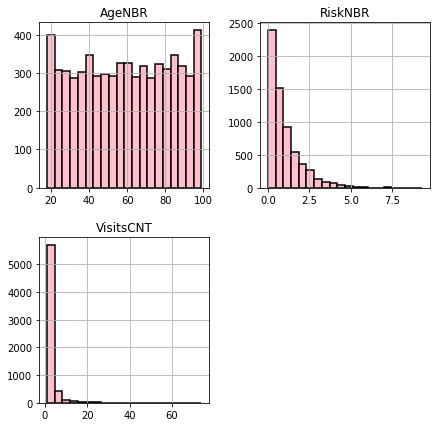

In [18]:
data[["AgeNBR", "VisitsCNT", "RiskNBR"]].hist(figsize = (7, 7),bins = 20, color = "pink", edgecolor = "black", linewidth = 1.5)
data[["AgeNBR", "VisitsCNT", "RiskNBR"]].boxplot(figsize = (7, 7), color = "pink" )
plt.show()

**Normality**


1.   Below are the qqplots for each continuous variable. Qqplot is used to check the normality of age, visitCNT, and riskNBR. The plot that doesn't fall around the 45 degree diagonal line indicates that the variable is not normal. In conclusion, ageNBR, visitsCNT, and RiskNBR are not not normal and they are not suitable for using t.test in hypothesis testing. Instead, Wilcoxon Rank test is a better test for hypothesis testing. 
2.   The not-normal qqplots also explain that these variables are not suitable for being used as a dependent variable (y) for prediction in univariate or multivariate regression modeling.


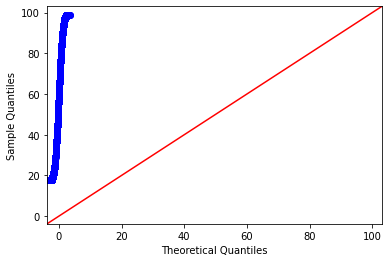

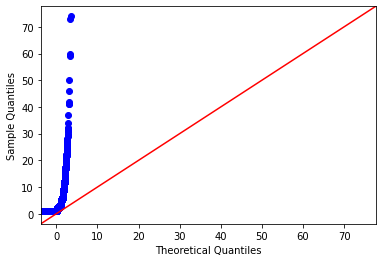

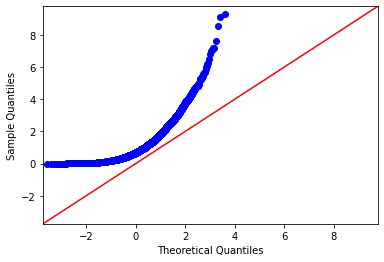

In [19]:
sm.qqplot(data["AgeNBR"], line = '45')
sm.qqplot(data["VisitsCNT"], line = '45')
sm.qqplot(data["RiskNBR"], line = '45')
plt.show()

#Box Plot


1. Below are the boxplot, scatter plot, and pearson correlation matrix heatmap that are used to determine the correlation between the continuous variables.
2. I'd assume that people who are old would have higher RiskNBR. However, by looking at the boxplot for RiskNBR and VisitsCNT, the median age with a higher riskNBR peaks at 44 and the median age with a higher RiskNBR slightly descreases until age 67.
3.  Note: The line in the middle of the box is the median and the top and bottom of the box are the 75% and 25% interquartile range (IQR). The straigt line outside the box indicates the minimum and maximum RiskNBR of each age group



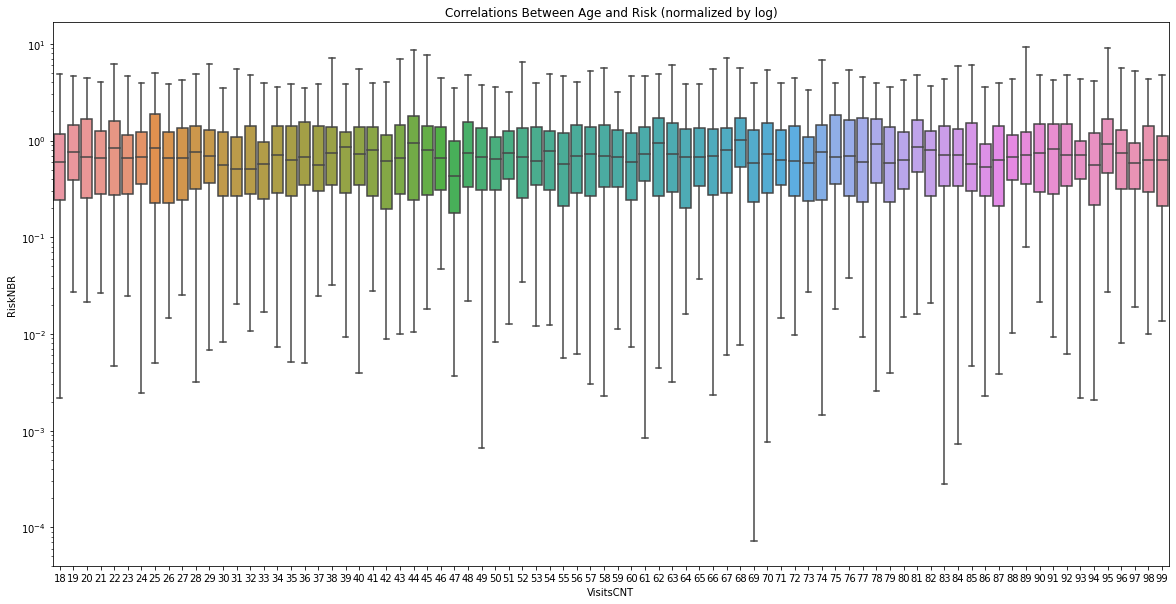

In [20]:
plt.figure(figsize= (20, 10))
sns.boxplot(x = "AgeNBR", y = "RiskNBR", data = data, whis= 20)
plt.yscale("log")
plt.title("Correlations Between Age and Risk (normalized by log)")
plt.xlabel("VisitsCNT")
plt.ylabel("RiskNBR")
plt.show()


The scatter plot below is used to determine the correlation between VisitCNT and RiskNBR. The plot below does not show any linear correlation between the two variables.  

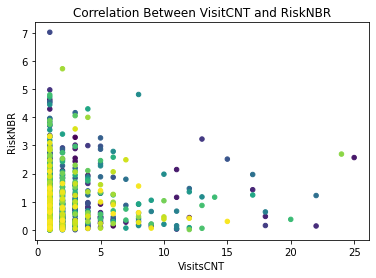

In [21]:
data_first1000 = data[:1000]
data_first1000.plot.scatter("VisitsCNT", "RiskNBR", c = data_first1000.index, cmap = plt.cm.viridis, colorbar = False)
plt.title("Correlation Between VisitCNT and RiskNBR")
plt.show()

Below are the Pearson Correlation matrix and the heatmap for all continuous variables. The index ranges from -1 and 1. A strong correlation would have an index close to -1 or 1. These indexes that are near zero indicate the AgeNBR, VisitsCNT, and RiskNBR are not correlated.

             AgeNBR  VisitsCNT   RiskNBR
AgeNBR     1.000000   0.014389  0.019294
VisitsCNT  0.014389   1.000000 -0.005566
RiskNBR    0.019294  -0.005566  1.000000


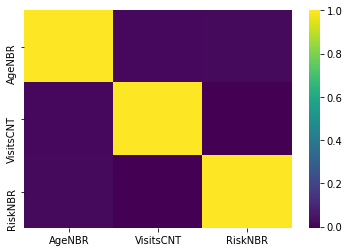

In [22]:
contin_data = data[["AgeNBR", "VisitsCNT", "RiskNBR"]]
C = contin_data.corr()
print(C)
sns.heatmap(C, cmap= "viridis")
plt.show()

**Correlation Between Categorical Variables and Continuous Variables**


1.   Let's determine the correlation between the categorical and continuous variables by looking at the bar charts and dython association heatmap. Figure 1 represents the relationship for genderCD, clinic, and visitCNT. The distributions among female and male patient visiting in each clinic is releatively equal.
2. Figure 2 represents the relationship between modalityDSC, clinic, and VisitCNT. As mentioned in the summary, the top 4 popular services based on patient visits are physical therapy, acupuncture, chiropractic, and mental health.
3. The dython association heatmap indicates the associates between the categorical and continuous variables. However, besides visitCNT and modalityDSC that moderately associated, all other variables are not associated. The pointbisserial correlation test results also indicate the two varibles are correlated.



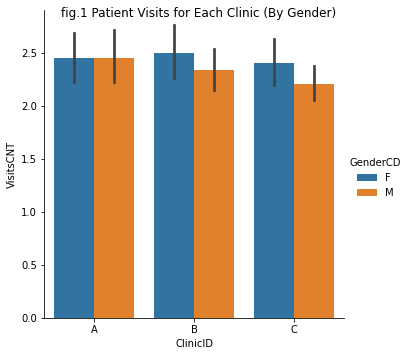

In [23]:
g = sns.catplot(data=data, kind="bar", x="ClinicID", y= "VisitsCNT", hue="GenderCD")
g.fig.suptitle('fig.1 Patient Visits for Each Clinic (By Gender)')
plt.show()

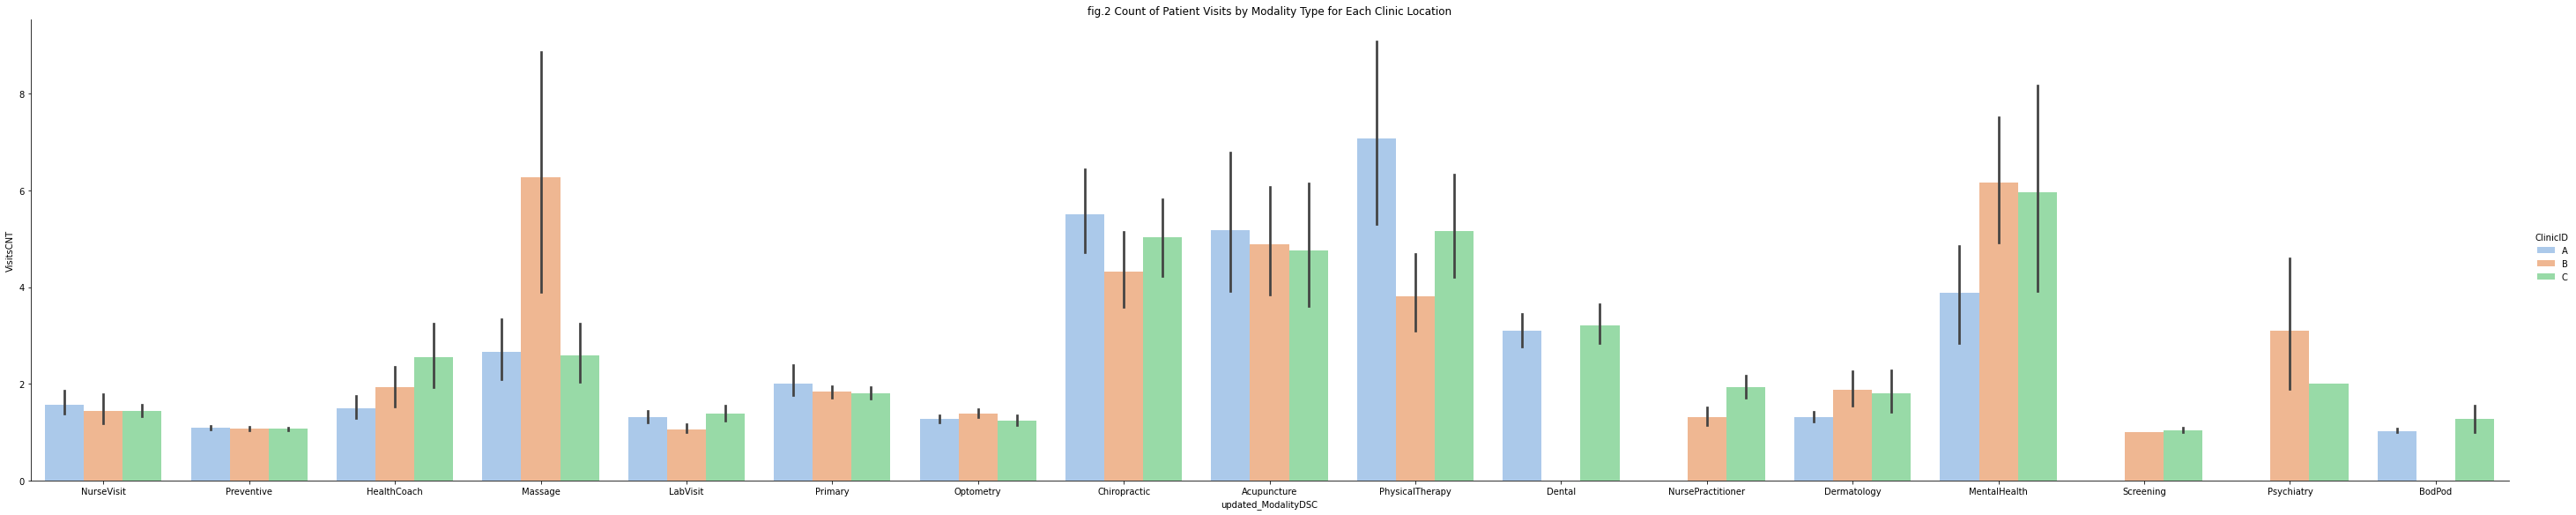

In [27]:
sns.catplot(data=data, kind="bar", x="updated_ModalityDSC", y="VisitsCNT", hue="ClinicID", palette="pastel", height = 8, aspect = 5)
plt.title("fig.2 Count of Patient Visits by Modality Type for Each Clinic Location")
plt.show()

**One hot coding for Categorical Variables for Pointbisserial Correlation Test**


1.   The Pointbisserial Correlation test results explain the strong correlation  between Modality class and VisitCNT by p-value (statistical significance of p < 0.05

In [26]:
le = LabelEncoder()

label_data = data[["RelationshipDSC", "GenderCD", "ClinicID","updated_ModalityDSC"]].apply(lambda x: le.fit_transform(x)).rename(columns = {"RelationshipDSC":"RelationshipDSC_class", "GenderCD":"GenderCD_class", "ClinicID": "ClinicID_class", "updated_ModalityDSC":"Modality_class"})
data = pd.concat([data, label_data], axis = 1)

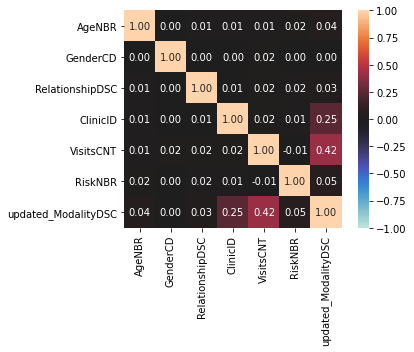

In [28]:
from dython.nominal import associations
subset = data.drop(columns= ["PatientID", "GenderCD_class", "RelationshipDSC_class", "ClinicID_class", "ModalityDSC", "Modality_class"])
associations(subset)

plt.rcParams["figure.figsize"]= 5,5

In [29]:
data.head(3)

,PatientID,AgeNBR,GenderCD,RelationshipDSC,ClinicID,ModalityDSC,VisitsCNT,RiskNBR,updated_ModalityDSC,RelationshipDSC_class,GenderCD_class,ClinicID_class,Modality_class
1,169233,46,F,Dependent,A,Nurse Visit,3,0.165685,NurseVisit,0,0,0,10
2,42880,59,F,Employee,B,|||Preventive,1,1.133132,Preventive,1,0,1,13
3,118044,36,F,Employee,B,Health Coach,1,0.701008,HealthCoach,1,0,1,5


In [30]:
def pointbisserial_func(x, y):
  pbc = pointbiserialr(x, y)
  print("the point biserial correlation between", x.name, "and", y.name, "is", pbc[0], 
      "and the p-value is", pbc[1])

In [31]:
pointbisserial_func(data["ClinicID_class"],data["VisitsCNT"] )
pointbisserial_func(data["ClinicID_class"],data["RiskNBR"] )
pointbisserial_func(data["ClinicID_class"],data["AgeNBR"] )
pointbisserial_func(data["Modality_class"],data["VisitsCNT"] )
pointbisserial_func(data["Modality_class"],data["RiskNBR"] )
pointbisserial_func(data["Modality_class"],data["AgeNBR"] )
pointbisserial_func(data["RelationshipDSC_class"],data["VisitsCNT"] )
pointbisserial_func(data["RelationshipDSC_class"],data["RiskNBR"] )
pointbisserial_func(data["RelationshipDSC_class"],data["AgeNBR"] )
pointbisserial_func(data["GenderCD_class"],data["VisitsCNT"] )
pointbisserial_func(data["GenderCD_class"],data["RiskNBR"] )
pointbisserial_func(data["GenderCD_class"],data["AgeNBR"] )

the point biserial correlation between ClinicID_class and VisitsCNT is -0.01739232338167553 and the p-value is 0.1648196814221005
the point biserial correlation between ClinicID_class and RiskNBR is 0.0023885321283083336 and the p-value is 0.8487240807476877
the point biserial correlation between ClinicID_class and AgeNBR is 0.007167662571674697 and the p-value is 0.5670432139920979
the point biserial correlation between Modality_class and VisitsCNT is -0.21583673125177794 and the p-value is 3.922746565023128e-68
the point biserial correlation between Modality_class and RiskNBR is 0.013174582571192568 and the p-value is 0.2927270842362156
the point biserial correlation between Modality_class and AgeNBR is 0.006013190396248117 and the p-value is 0.6310757846135844
the point biserial correlation between RelationshipDSC_class and VisitsCNT is 0.019862853907143 and the p-value is 0.11265106409442004
the point biserial correlation between RelationshipDSC_class and RiskNBR is 0.0153482021831

**Patient Behavior** - IDs that appear more than once


1.   The categorical bar plot in the previous session show that the patient ID appear at least twice if they have a dependent who also visited the clinic. Any patient ID that appear more than 3 times indicate the another visit to modality by the employee or dependent. This helps analyze the activity of each patient and the variety of services being seen. For example, an employee (patient ID 13096) had a primary visit and nurse visit

2. For this dataset, only 5% of the patient ID population (280 / 6088) who visited a clinic have used more than one service.

In [32]:
appear_more_than_once = data.groupby("PatientID")["PatientID"].count()
appear_more_than_once_1 = appear_more_than_once[ appear_more_than_once>= 2]
appear_more_than_threetimes = appear_more_than_once[ appear_more_than_once>= 3]
data[data.PatientID == 13096]

,PatientID,AgeNBR,GenderCD,RelationshipDSC,ClinicID,ModalityDSC,VisitsCNT,RiskNBR,updated_ModalityDSC,RelationshipDSC_class,GenderCD_class,ClinicID_class,Modality_class
572,13096,72,M,Dependent,A,|||Health Coach,2,0.469890,HealthCoach,0,1,0,5
3919,13096,54,F,Employee,A,Primary,1,0.079440,Primary,1,0,0,14
5612,13096,90,F,Employee,A,Nurse Visit,1,2.731954,NurseVisit,1,0,0,10


In [33]:
appear_more_than_once.shape, appear_more_than_once_1.shape, appear_more_than_threetimes.shape

((6088,), (280,), (12,))

**Chi Square Test for Correlation Between Categorical Variables**

H0: categorical variable A and categorical variable B are not associated.
HA : categorical variable A and categorical variable B are associated.
1.   In conclusion, the p-value is (p_value < 0.05). We reject the null hypothesis. ClinicID and ModalityDSC are associated.




In [34]:
def chisquare(contingency_table):
  res = stat()
  res.chisq(contingency_table)
  print(res.summary)

In [35]:
gender_df = pd.crosstab(data["ClinicID"], data["GenderCD"], margins= False)
chisquare(gender_df)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       1.64412   0.439525
Log-likelihood     2       1.64409   0.439531



In [36]:
clinic_ra = pd.crosstab(data["ClinicID"], data["RelationshipDSC_class"], margins= False)
chisquare(clinic_ra)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       2.30508   0.315834
Log-likelihood     2       2.30853   0.315289



In [37]:
modality_gender = pd.crosstab(data["ClinicID"], data["ModalityDSC"], margins= False)
chisquare(modality_gender)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson           66       827.791  4.00595e-132
Log-likelihood    66       997.024  2.71127e-166



In [38]:
data.groupby("ClinicID")["PatientID"].nunique() /data.PatientID.nunique()

ClinicID
A    0.352661
B    0.277595
C    0.369744
Name: PatientID, dtype: float64

# K Prototypes Clustering 

Based on the statistical test results, let's use modality DSC, ClinicID, and three continuous variables (Age, VisitCNT, RiskNBR) for K Prototype (a mixed type) clustering to see the natural group for these variables.


**Data Preprocessing**

In [39]:
# normalize the continuous variable
min_max_tr = lambda x: (x - x.min()) / (x.max() - x.min())
normalized_subset = contin_data
normalized_subset = normalized_subset.transform(min_max_tr)
cate_subset = data[["ClinicID_class", "Modality_class"]]
# add two categorical variables
normalized_subset = pd.concat([normalized_subset, cate_subset] , axis = 1)

#create randomized train test dataset
msk = np.random.rand(len(normalized_subset)) <= 0.8
train = normalized_subset[msk]
test = normalized_subset[~msk]

In [40]:
train.shape, test.shape

((5128, 5), (1252, 5))

K Prototypes Clustering

*   plot number clusters against the cost functin for k prototypes to choose the optimal number of clusters (K). 
*   by looking at the plot below, looks like the curve slightly bends at k =3.  



<function matplotlib.pyplot.show>

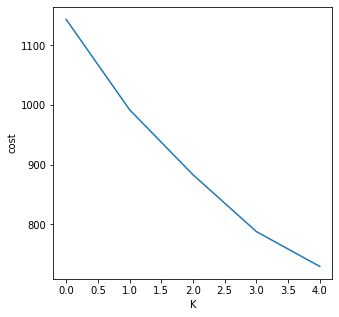

In [47]:
#Choosing optimal K value
cost = []
X = train
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=8,n_init=50) 
    kproto.fit_predict(X, categorical=[3,4])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show()

In [41]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=3, init='Huang', verbose=0, random_state=42,max_iter=10, n_init=50,n_jobs=-2,gamma=.25) 
clusters = kproto.fit_predict(train, categorical=[3,4])

In [42]:
train['cluster_id'] = clusters
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,AgeNBR,VisitsCNT,RiskNBR,ClinicID_class,Modality_class,cluster_id
1,0.345679,0.027397,0.017784,0,10,2
2,0.506173,0.000000,0.121674,1,13,1
3,0.222222,0.000000,0.075270,1,5,1
5,0.296296,0.000000,0.145113,1,6,1
7,0.271605,0.013699,0.050386,0,10,2


**test result for model 1 ( k= 3, AgeNBR	VisitsCNT	RiskNBR	ClinicID_class	Modality_class)**
by looking at the cluster centroids for each cluster, ageNBR and ModalityDSC are not clustered well. The modality is clustered around Primary and Age is clustered around 58. Let's re-perform clustering by removing AgeNBR and ModalityDSC.

In [43]:
result_centroids = kproto.cluster_centroids_
con_centroids_df = pd.DataFrame(result_centroids[0], columns= ["AgeNBR", "VisitsCNT", "RiskNBR"])
cat_centroids_df = pd.DataFrame(result_centroids[1], columns= ["ClinicID_class", "Modality_class"])
#un-normalize
def un_tr(x, y): 
  df = y * (np.max(x) - np.min(x)) + np.min(x)
  return df

un_df = un_tr(contin_data, con_centroids_df)
un_normalized_df = pd.concat([un_df,cat_centroids_df ], axis = 1)
un_normalized_df

,AgeNBR,VisitsCNT,RiskNBR,ClinicID_class,Modality_class
0,58.586152,2.352537,1.004820,2.0,14.0
1,59.021352,2.454804,0.958852,1.0,14.0
2,58.386128,2.476242,1.007429,0.0,14.0


**Model 2 (k =3, VisitsCNT,	RiskNBR,	ClinicID_class)**




In [44]:
train_2 = train.drop(columns = ["AgeNBR", "Modality_class"], axis=1 )

In [45]:
# Running K-Prototype clustering again
kproto2 = KPrototypes(n_clusters=3, init='Huang', verbose=0, random_state=42,max_iter=10, n_init=50,n_jobs=-2,gamma=.25) 
clusters2 = kproto2.fit_predict(train_2, categorical=[2])

The cluster result with a few variables indicates that each clinic is custered with RiskNBR around 1 and VisitCNT around 2. More variables that are associated are needed for k prototypes clustering.  

In [46]:
result2_centroids = kproto2.cluster_centroids_
con_centroids_df2 = pd.DataFrame(result2_centroids[0], columns= ["VisitsCNT", "RiskNBR", "ClinicID_class"])
cat_centroids_df2 = pd.DataFrame(result2_centroids[1], columns= ["Cluster_id"])
#un-normalize
def un_tr(x, y): 
  df = y * (np.max(x) - np.min(x)) + np.min(x)
  return df

un_df2 = un_tr(contin_data.iloc[:,1:3], con_centroids_df2.iloc[:,0:2])
un_normalized_df2 = pd.concat([un_df2, con_centroids_df2.iloc[:,-1] ], axis = 1)
un_normalized_df2 = pd.concat([un_normalized_df2, cat_centroids_df2 ], axis = 1)
un_normalized_df2

,VisitsCNT,RiskNBR,ClinicID_class,Cluster_id
0,2.352537,1.004820,0.0,2.0
1,2.454804,0.958852,1.0,1.0
2,2.476242,1.007429,2.0,0.0


**3D graph for clustering**

In [47]:
un_normalized_train2_df = un_tr(contin_data.iloc[:,1:3], train_2.iloc[:,0:2])
un_normalized_train2_df = pd.concat([un_normalized_train2_df, train_2.iloc[:,2:4] ], axis = 1)
un_normalized_train2_df.head()

,VisitsCNT,RiskNBR,ClinicID_class,cluster_id
1,3.0,0.165685,0,2
2,1.0,1.133132,1,1
3,1.0,0.701008,1,1
5,1.0,1.351404,1,1
7,2.0,0.469282,0,2


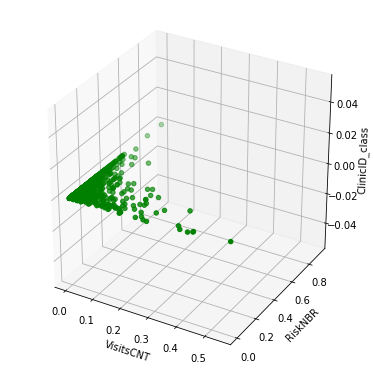

In [48]:
train_2['cluster_id'] = clusters
from mpl_toolkits.mplot3d import Axes3D
X = train_2.loc[(train["cluster_id"] == 1), "VisitsCNT"]
Y = train_2.loc[(train["cluster_id"] == 1), "RiskNBR"]
Z = train_2.loc[(train["cluster_id"] == 1), "ClinicID_class"]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X, Y, c = 'green')
ax.set_xlabel("VisitsCNT")
ax.set_ylabel("RiskNBR")
ax.set_zlabel("ClinicID_class")
plt.show()

##Next Steps


1.   Analyze user (patient) behaviors by understanding the patients who visited a clinic have used more than one serice with time and frequency. e.g. timeseries analysis for VisitsCNT. 
2.  Analyze patient behaviors by determining if they use onsite clinic more than online or vice versa. Predict patient visits by clinic classification.
3. Incorporate more continuous variables to understand the natural grouping among continuous variables and categorical variables for clustering.
4. understand seasonality of patient visits
